In [1]:
!pip install pydicom matplotlib numpy SimpleITK dcmqi monai
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from monai.transforms import Compose
import threading

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 42.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.0 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# PROCESSING FUNCTIONS (FIXED)
def pad_to_depth(x, target_depth):
    current_depth = x.shape[1]
    padded_depth = ((current_depth + 3) // 4) * 4
    pad_amount = padded_depth - current_depth
    if pad_amount > 0:
        pad_tensor = torch.zeros(x.size(0), pad_amount, x.size(2), x.size(3), 
                              device=x.device, dtype=x.dtype)
        x = torch.cat([x, pad_tensor], dim=1)
    return x

def get_patient_folders(root_path):
    return [
        os.path.join(root_path, d) 
        for d in os.listdir(root_path) 
        if os.path.isdir(os.path.join(root_path, d)) 
        and "im_1" in os.listdir(os.path.join(root_path, d))
    ]
    
def get_dicom_series(directory):

    reader = sitk.ImageSeriesReader()
    try:
        series_ids = reader.GetGDCMSeriesIDs(directory)
        if not series_ids:
            return None
        
        dicom_files = reader.GetGDCMSeriesFileNames(directory, series_ids[0])
        reader.SetFileNames(dicom_files)
        return reader.Execute()
    except Exception as e:

        print(f"Error loading DICOM from {directory}: {str(e)}")
        return None

def convert_seg_dicom_to_mha(im3_path, output_base_dir, patient_id):
    seg_dcm_files = [f for f in os.listdir(im3_path) if f.lower().endswith(".dcm")]
    if not seg_dcm_files:
        return None

    output_dir = os.path.join(output_base_dir, patient_id)
    os.makedirs(output_dir, exist_ok=True)
    
    convert_cmd = [
        "segimage2itkimage",
        "--inputDICOM", os.path.join(im3_path, seg_dcm_files[0]),
        "--outputDirectory", output_dir,
        "-t", "mha",
        "-p", "segmentation"
    ]

    result = subprocess.run(convert_cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Conversion failed for {patient_id}. Error:\n{result.stderr}")
        return None

    mha_files = [f for f in os.listdir(output_dir) 
               if f.startswith("segmentation") and f.endswith(".mha")]
    return os.path.join(output_dir, mha_files[0]) if mha_files else None

def process_files():
    processed_data = []
    target_shape = (128, 128, 72)

    base_path = "/kaggle/input/ctpel13/"
    working_dir = "/kaggle/working/converted_segmentations/"
    os.makedirs(working_dir, exist_ok=True)

    patients = get_patient_folders(base_path)

    for patient in patients:
        patient_id = os.path.basename(patient)
        print(f"\nProcessing: {patient_id}")
        
        ct_path = os.path.join(patient, "im_1")
        seg_path = os.path.join(patient, "im_3")

        # 1. Load CT scan
        ct_image = get_dicom_series(ct_path)
        if not ct_image:
            print(f"Skipping {patient_id} - CT load failed")
            continue

        # 2. Process segmentation
        seg_file = convert_seg_dicom_to_mha(seg_path, working_dir, patient_id)
        if not seg_file:
            print(f"Skipping {patient_id} - Segmentation conversion failed")

            continue
            
        try:
            # 3. Load and resample segmentation
            seg_image = sitk.ReadImage(seg_file)
            
            resampler = sitk.ResampleImageFilter()
            resampler.SetReferenceImage(ct_image)
            resampler.SetInterpolator(sitk.sitkNearestNeighbor)
            resampled_seg = resampler.Execute(seg_image)


            # 4. Convert to numpy arrays
            ct_array = sitk.GetArrayFromImage(ct_image)  # (D, H, W)
            seg_array = sitk.GetArrayFromImage(resampled_seg)

            # 5. Verify dimensions
            if ct_array.shape != seg_array.shape:
                print(f"Shape mismatch after resampling: {ct_array.shape} vs {seg_array.shape}")
                continue

            # 6. Convert to tensors and resize
            ct_tensor = torch.tensor(ct_array).float().unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
            seg_tensor = torch.tensor(seg_array).float().unsqueeze(0).unsqueeze(0)

            ct_resized = F.interpolate(ct_tensor, size=target_shape, mode='trilinear').squeeze()
            seg_resized = F.interpolate(seg_tensor, size=target_shape, mode='nearest').squeeze()

            seg_final = (seg_resized > 0.5).float().numpy()

            # 8. Store processed data
            # In process_files():
            processed_data.append({
                'filename': patient_id,
                'ct': ct_resized.numpy().astype(np.float32),  # (H, W, D)
                'seg': seg_final.astype(np.float32),          # (H, W, D)
                'original_shape': ct_array.shape,
                'processed_shape': target_shape
            })

        except Exception as e:
            print(f"Error processing {patient_id}: {str(e)}")
            continue

    return processed_data
processed_data = process_files()
print(f"Processed {len(processed_data)} samples")
    


Processing: 5F3E9A19B47C2EAD

Processing: 5BE1ADA090E1EB9C

Processing: 31E1D28ADE38ABA9

Processing: 3F2E8686E524ABCA

Processing: 02CC41B35F6C8145

Processing: 56CA1FFF09488D70

Processing: 4CD9674D8668698C

Processing: 08FF8BEBB1FB756A

Processing: 5B6D4F35387FF59C

Processing: 11BC311A21A22818

Processing: 0AD7CE889B4FB16F

Processing: 1D1D8ECAC96EFAA5

Processing: 9E8122CBCB107AC3

Processing: 64C38A134BB232A0

Processing: 9FB69D514F663A2B

Processing: 26DD3530EC0566E9

Processing: 3B3256E6694B0ABE

Processing: 06BE6C20741AFADD

Processing: 7A84C4C355AAF522

Processing: 0A44743795D421F7

Processing: 47DF7844DE611A35

Processing: 5A48C85404AB8CFD

Processing: 08D745849406C9D5

Processing: 2DD9A1B65346D271

Processing: 56A09B65B422A9C3

Processing: 0FC3188AAA7E6851

Processing: 3E934A9F0D559A6F

Processing: 7D8E6E1C05D04B9D

Processing: 0D0C5A034B94C222
Processed 29 samples


Keys: dict_keys(['filename', 'ct', 'seg', 'original_shape', 'processed_shape'])
CT shape: (128, 128, 72)
Seg shape: (128, 128, 72)
Seg unique values: [0. 1.]


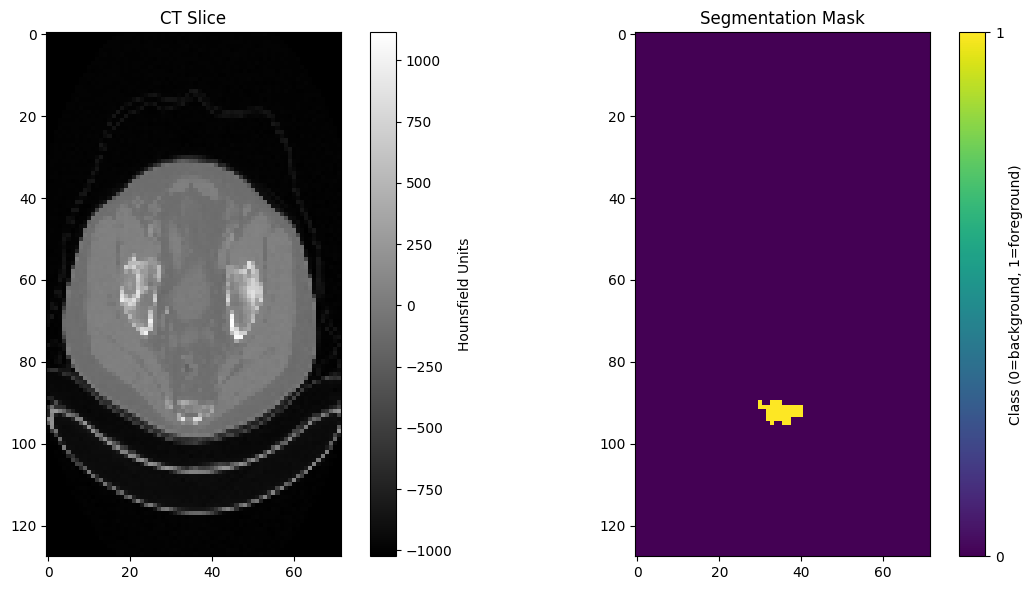

In [36]:
# Check first sample
sample = processed_data[14]
print("Keys:", sample.keys())
print("CT shape:", sample['ct'].shape)
print("Seg shape:", sample['seg'].shape)
print("Seg unique values:", np.unique(sample['seg']))
def plot_sample(ct, seg, slice_idx=36):
    """Plot CT slice and segmentation mask side by side"""
    plt.figure(figsize=(12, 6))
    
    # CT slice
    plt.subplot(121)
    plt.imshow(ct[slice_idx], cmap='gray')
    plt.title("CT Slice")
    plt.colorbar(label='Hounsfield Units')
    
    # Segmentation mask
    plt.subplot(122)
    plt.imshow(seg[slice_idx], cmap='viridis')
    plt.title("Segmentation Mask")
    plt.colorbar(ticks=[0, 1], label='Class (0=background, 1=foreground)')
    
    plt.tight_layout()
    plt.show()

# Plot sample
plot_sample(sample['ct'], sample['seg'])


Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

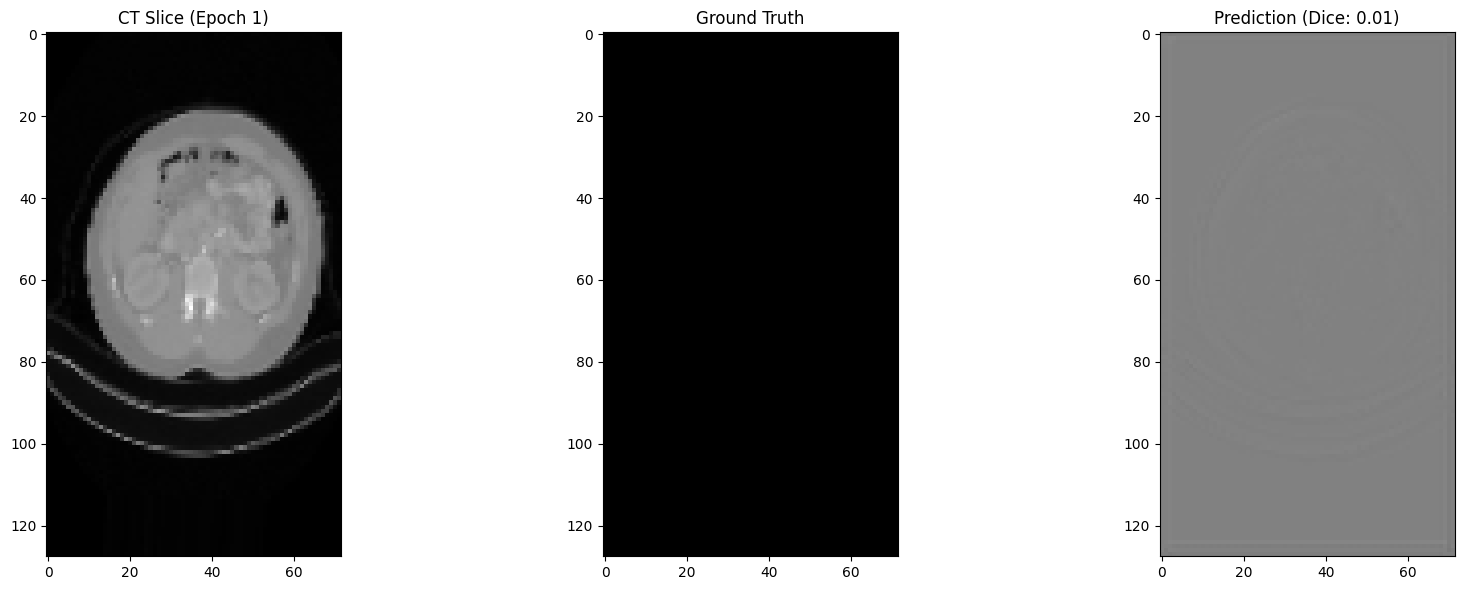

Epoch 1: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 1
Train Loss: 1.1739 | Dice: 0.0110
New best model saved with Dice: 0.0110


Epoch 2: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 2
Train Loss: 0.9865 | Dice: 0.0061


Epoch 3: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 3
Train Loss: 0.8962 | Dice: 0.0003


Epoch 4: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 4
Train Loss: 0.8485 | Dice: 0.0000


Epoch 5: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 5
Train Loss: 0.8215 | Dice: 0.0000


Epoch 6:   0%|          | 0/15 [00:00<?, ?it/s]

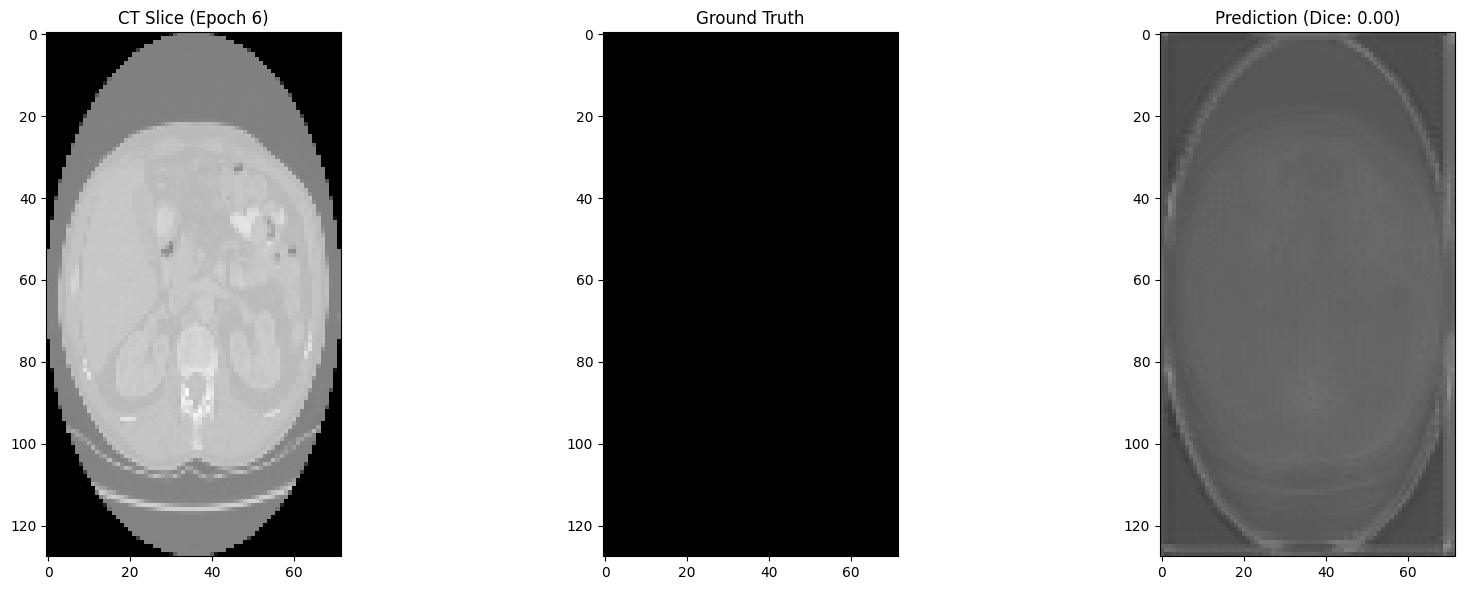

Epoch 6: 100%|██████████| 15/15 [00:28<00:00,  1.87s/it]



Epoch 6
Train Loss: 0.8003 | Dice: 0.0000


Epoch 7: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 7
Train Loss: 0.7774 | Dice: 0.0000


Epoch 8: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 8
Train Loss: 0.7586 | Dice: 0.0000


Epoch 9: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 9
Train Loss: 0.7347 | Dice: 0.0000


Epoch 10: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 10
Train Loss: 0.7151 | Dice: 0.0000


Epoch 11:   0%|          | 0/15 [00:00<?, ?it/s]

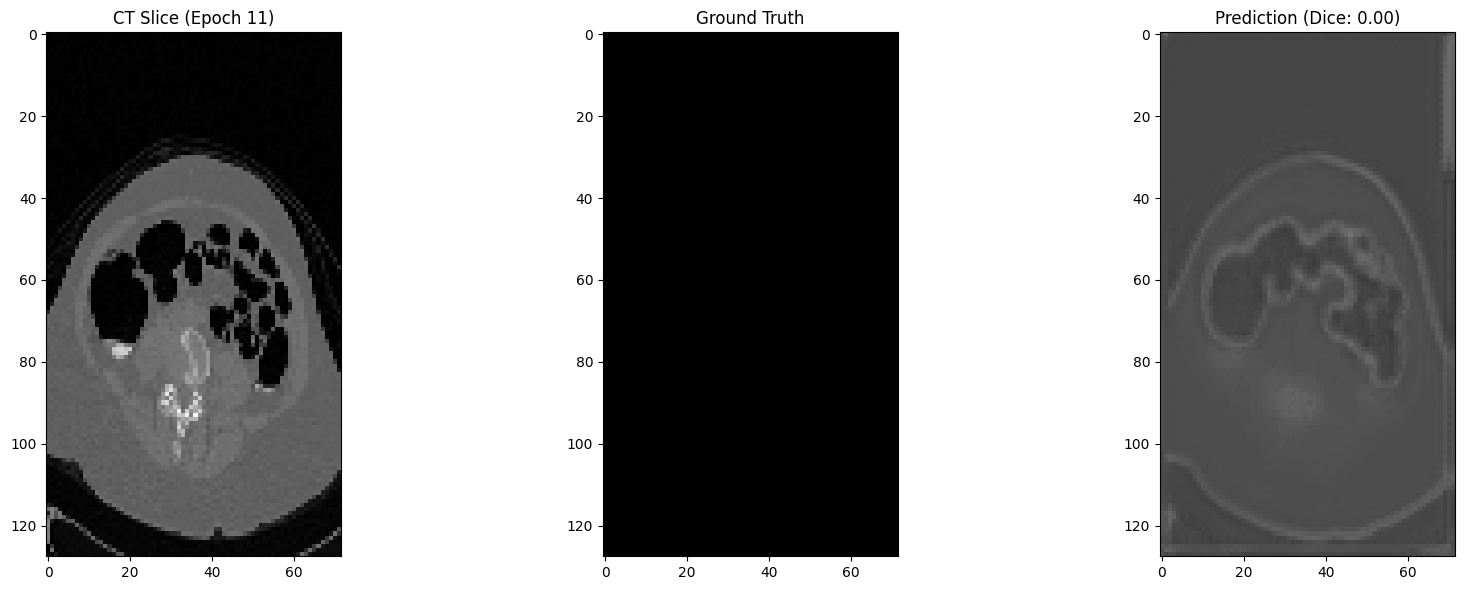

Epoch 11: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 11
Train Loss: 0.6941 | Dice: 0.0000


Epoch 12: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 12
Train Loss: 0.6781 | Dice: 0.0000


Epoch 13: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 13
Train Loss: 0.6670 | Dice: 0.0123
New best model saved with Dice: 0.0123


Epoch 14: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 14
Train Loss: 0.6525 | Dice: 0.0012


Epoch 15: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 15
Train Loss: 0.6412 | Dice: 0.0869
New best model saved with Dice: 0.0869


Epoch 16:   0%|          | 0/15 [00:00<?, ?it/s]

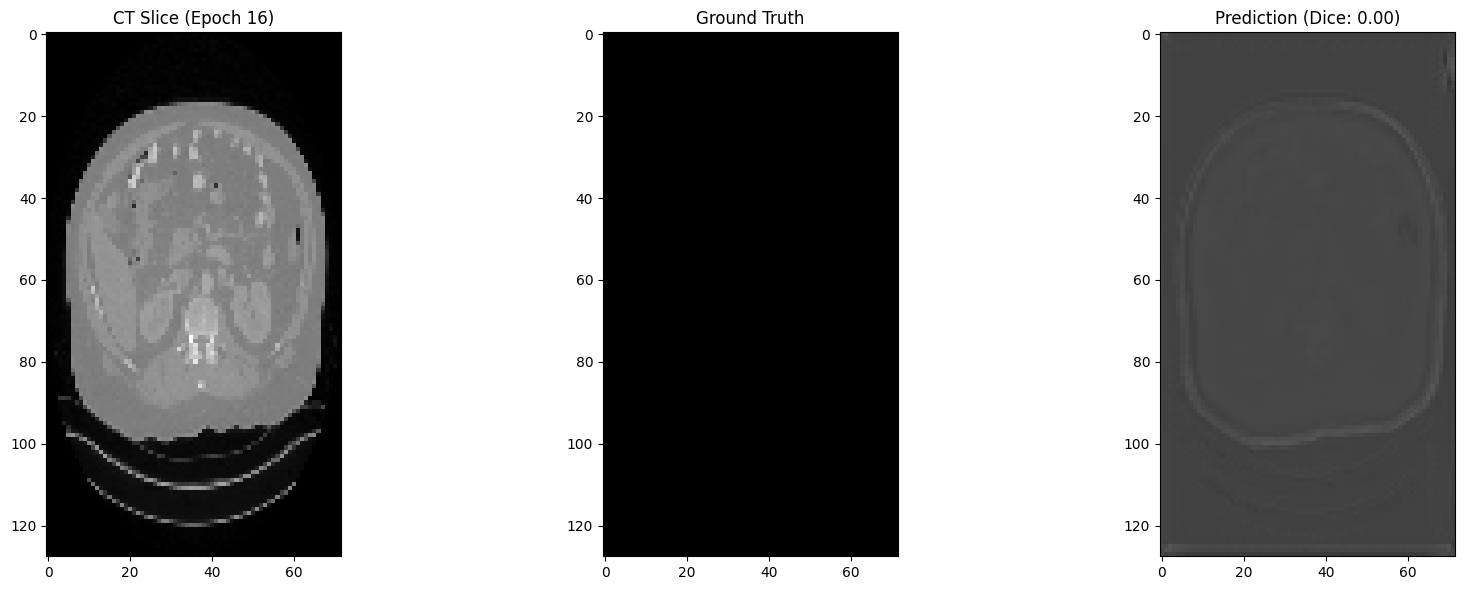

Epoch 16: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 16
Train Loss: 0.6279 | Dice: 0.0969
New best model saved with Dice: 0.0969


Epoch 17: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]



Epoch 17
Train Loss: 0.6137 | Dice: 0.1104
New best model saved with Dice: 0.1104


Epoch 18: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 18
Train Loss: 0.6030 | Dice: 0.2796
New best model saved with Dice: 0.2796


Epoch 19: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]



Epoch 19
Train Loss: 0.5903 | Dice: 0.4646
New best model saved with Dice: 0.4646


Epoch 20: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 20
Train Loss: 0.5795 | Dice: 0.4597


Epoch 21:   0%|          | 0/15 [00:00<?, ?it/s]

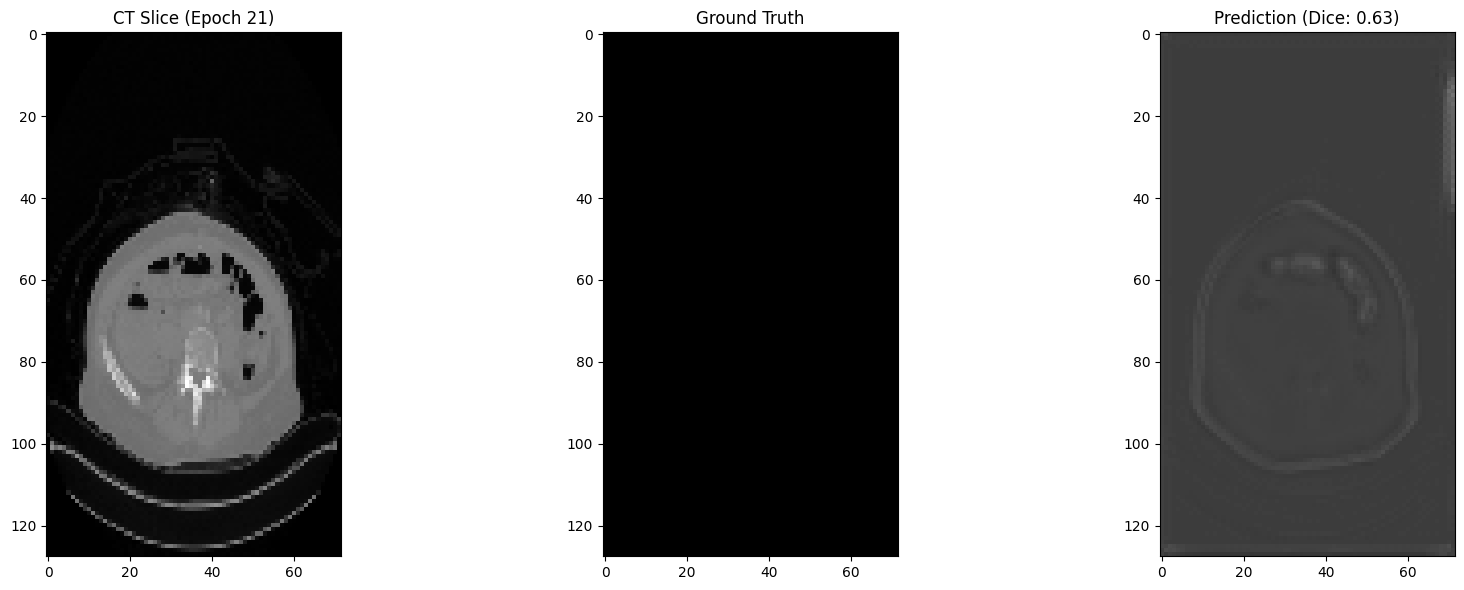

Epoch 21: 100%|██████████| 15/15 [00:28<00:00,  1.88s/it]



Epoch 21
Train Loss: 0.5690 | Dice: 0.4821
New best model saved with Dice: 0.4821


Epoch 22: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 22
Train Loss: 0.5575 | Dice: 0.5740
New best model saved with Dice: 0.5740


Epoch 23: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 23
Train Loss: 0.5467 | Dice: 0.5733


Epoch 24: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 24
Train Loss: 0.5350 | Dice: 0.4353


Epoch 25: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 25
Train Loss: 0.5248 | Dice: 0.4233


Epoch 26:   0%|          | 0/15 [00:00<?, ?it/s]

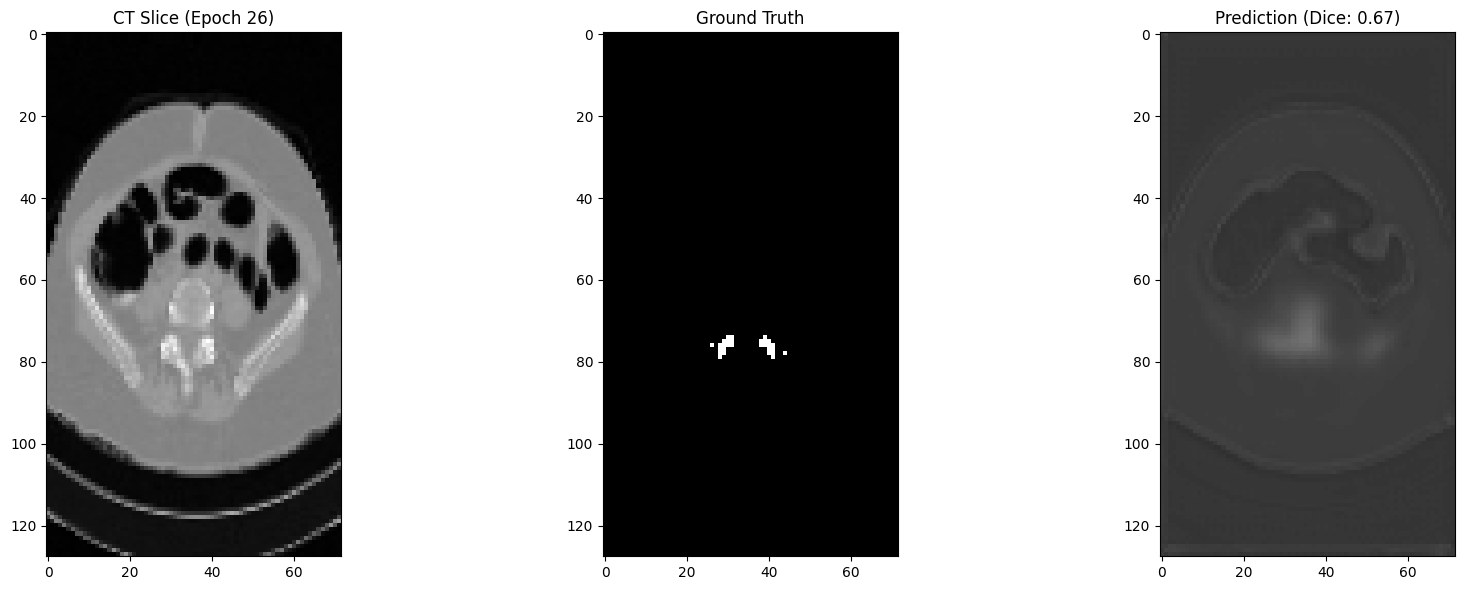

Epoch 26: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 26
Train Loss: 0.5151 | Dice: 0.5331


Epoch 27: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 27
Train Loss: 0.5038 | Dice: 0.6067
New best model saved with Dice: 0.6067


Epoch 28: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 28
Train Loss: 0.4936 | Dice: 0.6314
New best model saved with Dice: 0.6314


Epoch 29: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 29
Train Loss: 0.4832 | Dice: 0.6232


Epoch 30: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 30
Train Loss: 0.4744 | Dice: 0.6195


Epoch 31:   0%|          | 0/15 [00:00<?, ?it/s]

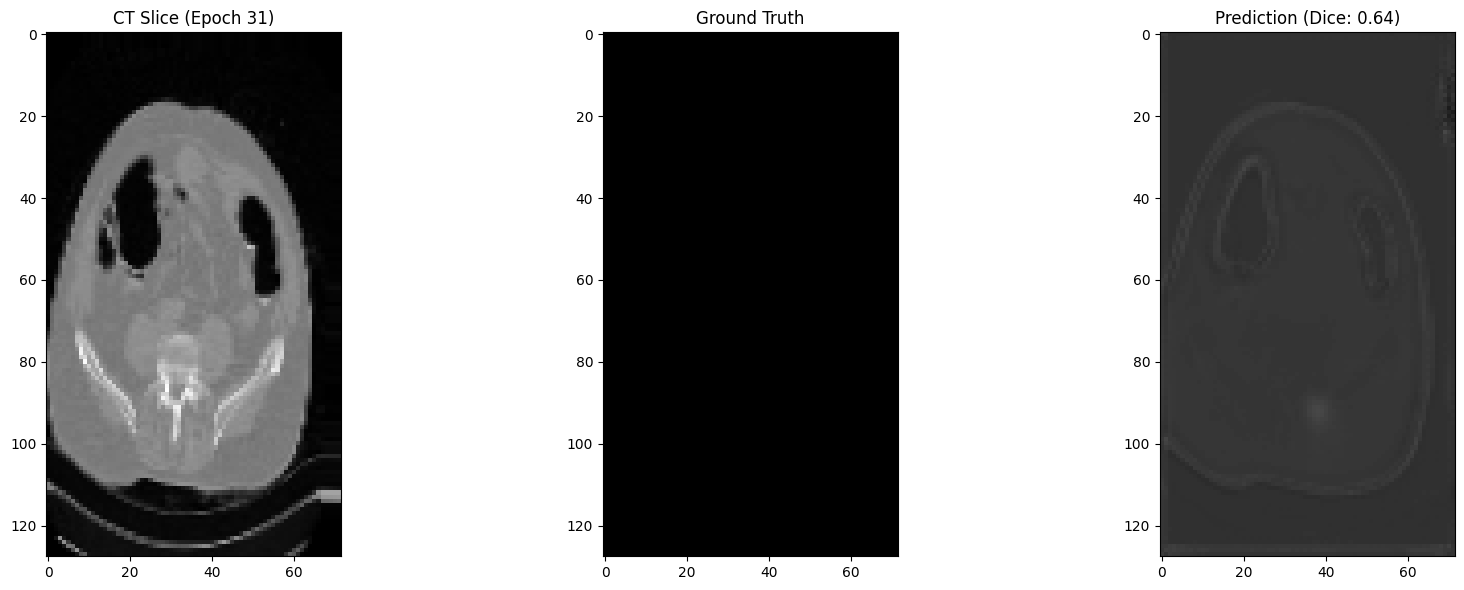

Epoch 31: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 31
Train Loss: 0.4655 | Dice: 0.6042


Epoch 32: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 32
Train Loss: 0.4561 | Dice: 0.6458
New best model saved with Dice: 0.6458


Epoch 33: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 33
Train Loss: 0.4474 | Dice: 0.7005
New best model saved with Dice: 0.7005


Epoch 34: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 34
Train Loss: 0.4378 | Dice: 0.6657


Epoch 35: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 35
Train Loss: 0.4285 | Dice: 0.6888


Epoch 36:   0%|          | 0/15 [00:00<?, ?it/s]

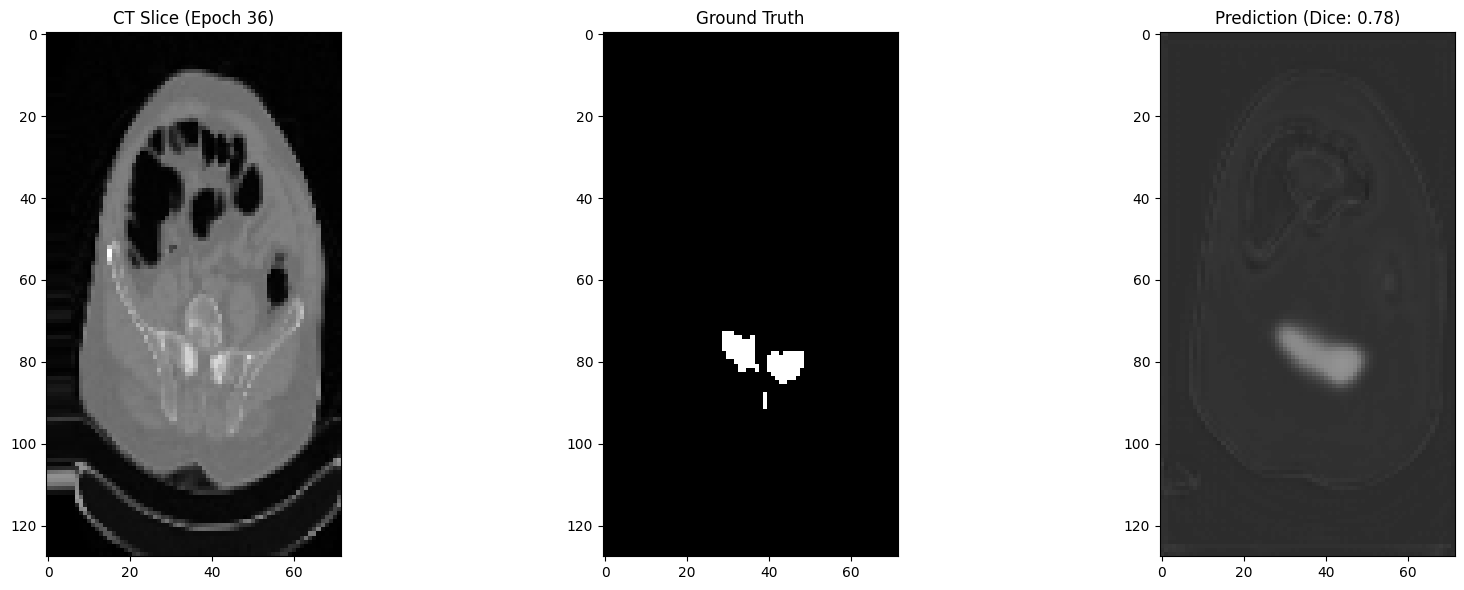

Epoch 36: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 36
Train Loss: 0.4212 | Dice: 0.7012
New best model saved with Dice: 0.7012


Epoch 37: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 37
Train Loss: 0.4156 | Dice: 0.6424


Epoch 38: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 38
Train Loss: 0.4054 | Dice: 0.7017
New best model saved with Dice: 0.7017


Epoch 39: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 39
Train Loss: 0.3974 | Dice: 0.6895


Epoch 40: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 40
Train Loss: 0.3891 | Dice: 0.7094
New best model saved with Dice: 0.7094


Epoch 41:   0%|          | 0/15 [00:00<?, ?it/s]

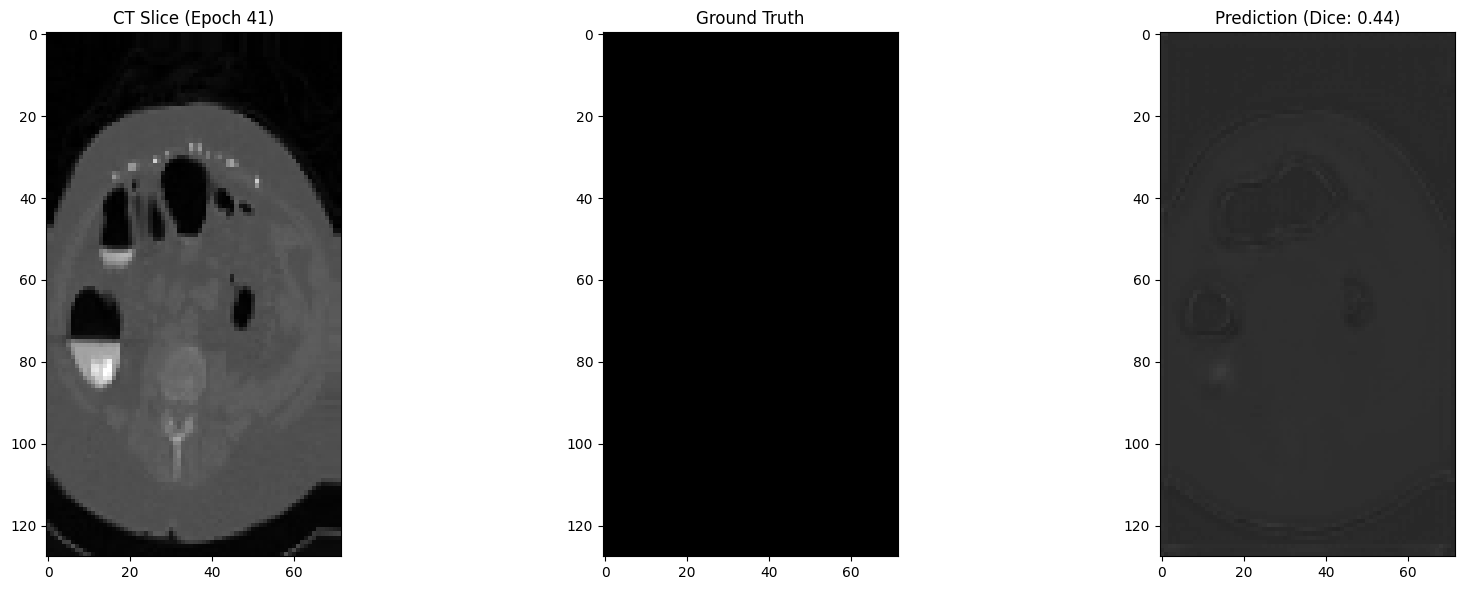

Epoch 41: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 41
Train Loss: 0.3822 | Dice: 0.6651


Epoch 42: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 42
Train Loss: 0.3746 | Dice: 0.6597


Epoch 43: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 43
Train Loss: 0.3678 | Dice: 0.6902


Epoch 44: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 44
Train Loss: 0.3604 | Dice: 0.7094


Epoch 45: 100%|██████████| 15/15 [00:28<00:00,  1.87s/it]



Epoch 45
Train Loss: 0.3560 | Dice: 0.7021


Epoch 46:   0%|          | 0/15 [00:00<?, ?it/s]

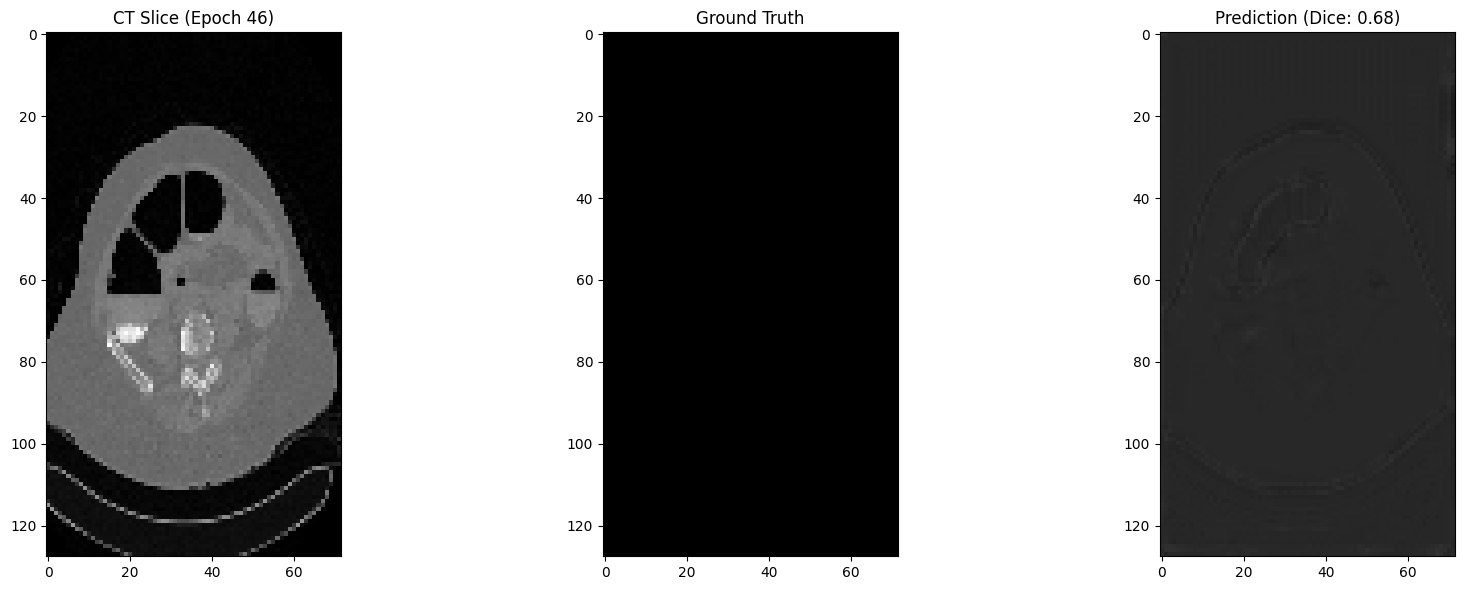

Epoch 46: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 46
Train Loss: 0.3483 | Dice: 0.6701


Epoch 47: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 47
Train Loss: 0.3405 | Dice: 0.7398
New best model saved with Dice: 0.7398


Epoch 48: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 48
Train Loss: 0.3345 | Dice: 0.7459
New best model saved with Dice: 0.7459


Epoch 49: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 49
Train Loss: 0.3284 | Dice: 0.7381


Epoch 50: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


Epoch 50
Train Loss: 0.3226 | Dice: 0.7409


In [32]:
# %% --------------------
# PART 0: IMPORTS (UPDATE MONAI TRANSFORMS)
# %% --------------------
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    RandAffined,
    RandFlipd,
    ScaleIntensityd,
    EnsureChannelFirstd,
    ToTensord,
    LambdaD
)

# %% --------------------
# PART 2: DATASET CLASS (CORRECTED)
# %% --------------------
class CTDataset(Dataset):
    def __init__(self, processed_data):
        self.data = processed_data
        self.transform = Compose([
            LambdaD(keys=['ct', 'seg'], func=lambda x: x[np.newaxis, ...]),
            ScaleIntensityd(keys=['ct'], minv=-1000.0, maxv=1000.0),
            RandAffined(
                keys=['ct', 'seg'],
                prob=0.5,
                rotate_range=(0.1, 0.1, 0.1),
                translate_range=(10, 10, 5),
                scale_range=(0.1, 0.1, 0.1),
                padding_mode='border',
                mode=('bilinear', 'nearest')
            ),
            RandFlipd(
                keys=['ct', 'seg'],
                spatial_axis=0,
                prob=0.5
            ),
            ToTensord(keys=['ct', 'seg'], dtype=torch.float32)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        data_dict = {
            'ct': sample['ct'].astype(np.float32),
            'seg': sample['seg'].astype(np.float32)
        }
        if self.transform:
            data_dict = self.transform(data_dict)
        return data_dict

def pad_to_depth(x, target_depth):
    current_depth = x.shape[1]
    if current_depth < target_depth:
        pad_amount = target_depth - current_depth
        pad_tensor = torch.zeros(x.shape[0], pad_amount, *x.shape[2:], 
                               device=x.device, dtype=x.dtype)
        return torch.cat([x, pad_tensor], dim=1)
    return x

def custom_collate_fn(batch):
    max_depth = max(sample['ct'].shape[1] for sample in batch)
    return {
        'ct': torch.stack([pad_to_depth(sample['ct'], max_depth) for sample in batch]),
        'seg': torch.stack([pad_to_depth(sample['seg'], max_depth) for sample in batch])
    }

# %% --------------------
# MODEL ARCHITECTURE
# %% --------------------
class MultiPassUNet3D(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, base_channels=32):
        super().__init__()
        self.encoder1 = self._block(in_channels, base_channels)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = self._block(base_channels, base_channels*2)
        self.pool2 = nn.MaxPool3d(2)
        
        self.bottleneck = self._block(base_channels*2, base_channels*4)
        
        self.upconv2 = nn.ConvTranspose3d(base_channels*4, base_channels*2, 2, stride=2)
        self.decoder2 = self._block(base_channels*4, base_channels*2)
        self.upconv1 = nn.ConvTranspose3d(base_channels*2, base_channels, 2, stride=2)
        self.decoder1 = self._block(base_channels*2, base_channels)
        
        self.conv = nn.Conv3d(base_channels, out_channels, 1)

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv3d(in_channels, features, 3, padding=1),
            nn.BatchNorm3d(features),
            nn.ReLU(inplace=True),
            nn.Conv3d(features, features, 3, padding=1),
            nn.BatchNorm3d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.conv(dec1)

def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + smooth) / (union + smooth)

# %% --------------------
# TRAINING FUNCTION WITH VISUALIZATION
# %% --------------------
def train(processed_data, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultiPassUNet3D(in_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    train_loader = DataLoader(
        CTDataset(processed_data),
        batch_size=2,
        shuffle=True,
        num_workers=2,
        collate_fn=custom_collate_fn,
        pin_memory=True
    )

    best_dice = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        dice_total = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            ct = batch['ct'].to(device)
            seg = batch['seg'].to(device)
            
            # First pass
            blank_context = torch.zeros_like(ct)
            input_pass1 = torch.cat([ct, blank_context], dim=1)
            output_pass1 = model(input_pass1)
            
            # Second pass
            with torch.no_grad():
                context = (torch.sigmoid(output_pass1) > 0.5).float()
            input_pass2 = torch.cat([ct, context], dim=1)
            output_pass2 = model(input_pass2)
            
            # Loss calculation
            loss = F.binary_cross_entropy_with_logits(output_pass1, seg) + \
                   F.binary_cross_entropy_with_logits(output_pass2, seg)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Metrics
            with torch.no_grad():
                dice = dice_score(torch.sigmoid(output_pass2), seg)
                epoch_loss += loss.item()
                dice_total += dice

            # Visualization every 5 epochs on first batch
            if epoch % 5 == 0 and batch_idx == 0:
                model.eval()
                with torch.no_grad():
                    sample_ct = ct[0].unsqueeze(0)
                    sample_seg = seg[0].unsqueeze(0)
                    
                    # Get predictions
                    blank = torch.zeros_like(sample_ct)
                    pred_pass1 = torch.sigmoid(model(torch.cat([sample_ct, blank], dim=1)))
                    context = (pred_pass1 > 0.5).float()
                    pred_pass2 = torch.sigmoid(model(torch.cat([sample_ct, context], dim=1)))

                    # Convert to numpy
                    ct_np = sample_ct.cpu().numpy()[0, 0]
                    seg_np = sample_seg.cpu().numpy()[0, 0]
                    pred_np = pred_pass2.cpu().numpy()[0, 0]

                    # Plotting
                    slice_idx = ct_np.shape[0] // 2
                    plt.figure(figsize=(18, 6))
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(ct_np[slice_idx], cmap='gray')
                    plt.title(f"CT Slice (Epoch {epoch+1})")
                    
                    plt.subplot(1, 3, 2)
                    plt.imshow(seg_np[slice_idx], cmap='gray')
                    plt.title("Ground Truth")
                    
                    plt.subplot(1, 3, 3)
                    plt.imshow(pred_np[slice_idx], cmap='gray', vmin=0, vmax=1)
                    plt.title(f"Prediction (Dice: {dice:.2f})")
                    
                    plt.tight_layout()
                    plt.show()
                model.train()

        avg_loss = epoch_loss / len(train_loader)
        avg_dice = dice_total / len(train_loader)
        scheduler.step(avg_loss)
        
        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f}")
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with Dice: {best_dice:.4f}")

if __name__ == "__main__":
    # Assuming processed_data is already loaded
    train(processed_data)

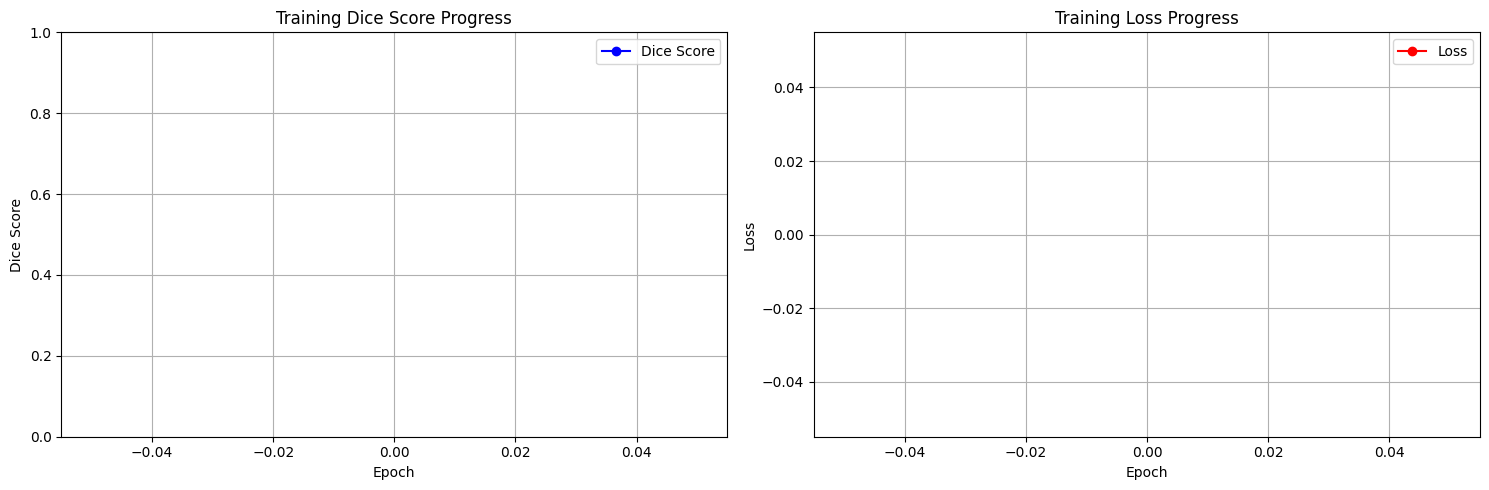

<ipython-input-30-0bbf1f854268>:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


RuntimeError: Error(s) in loading state_dict for UNet3D:
	Unexpected key(s) in state_dict: "encoder1.0.bias", "encoder1.3.bias", "encoder2.0.bias", "encoder2.3.bias", "bottleneck.0.bias", "bottleneck.3.bias", "decoder2.0.bias", "decoder2.3.bias", "decoder1.0.bias", "decoder1.3.bias". 
	size mismatch for encoder1.0.weight: copying a param with shape torch.Size([32, 2, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3, 3]).

In [30]:
# %% [markdown]
# ### Visualization of Training Metrics
# %% [code]
# Initialize metric tracking properly
Avg_dice_score = []
Avg_loss = []

plt.figure(figsize=(15, 5))

# Dice Score Plot
plt.subplot(1, 2, 1)
plt.plot(range(len(Avg_dice_score)), Avg_dice_score, 'b-o', label='Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training Dice Score Progress')
plt.ylim(0, 1)  # Add y-axis limits for dice score
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(len(Avg_loss)), Avg_loss, 'r-o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

def plot_comparison(batch, prediction):
    """Plot slices regardless of batch/channel dimensions"""
    # Remove batch and channel dimensions
    ct = batch['ct'].cpu().squeeze().numpy()     # (D, H, W)
    seg = batch['seg'].cpu().squeeze().numpy()   # (D, H, W)
    pred = prediction.squeeze()                  # (D, H, W)
    
    # Handle odd depths
    slice_idx = ct.shape[0] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # CT Slice
    axes[0].imshow(ct[slice_idx], cmap='gray')
    axes[0].set_title('CT Slice')
    axes[0].axis('off')
    
    # Ground Truth
    axes[1].imshow(seg[slice_idx], cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Prediction
    axes[2].imshow(pred[slice_idx], cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    plt.show()

def infer(ct_tensor):
    """Dual-pass inference with shape context (fixed dimension handling)"""
    with torch.no_grad():
        # Add channel dimension if needed
        if ct_tensor.dim() == 4:
            ct_tensor = ct_tensor.unsqueeze(1)  # (B, C, D, H, W)
            
        # First pass with blank context
        blank_context = torch.zeros_like(ct_tensor)
        input_pass1 = torch.cat([ct_tensor, blank_context], dim=1)
        output_pass1 = model(input_pass1)
        
        # Second pass with thresholded context
        context = (torch.sigmoid(output_pass1) > 0.5).float()
        input_pass2 = torch.cat([ct_tensor, context], dim=1)
        output_pass2 = model(input_pass2)
        
    return torch.sigmoid(output_pass2)

# Load best model with proper path handling
SAVE_DIR = "/kaggle/working"
best_model_path = os.path.join(SAVE_DIR, "best_model.pth")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Test evaluation with proper dimension handling
test_dice = 0.0
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        ct = batch['ct'].to(device)
        seg = batch['seg'].to(device)
        
        # Ensure correct dimensions
        if ct.dim() == 4:
            ct = ct.unsqueeze(1)  # Add channel dimension
        if seg.dim() == 4:
            seg = seg.unsqueeze(1)
            
        # Run inference
        pred = infer(ct)
        
        # Calculate metrics with proper dimension matching
        test_dice += dice_score(pred, seg)
        
        # Visualize first 3 cases
        if batch_idx < 3:
            plot_comparison(batch, pred.cpu().numpy())

print(f"\nTest Dice Score: {test_dice/len(test_loader):.4f}")